In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Exercise 1: Global approach to image description

In [2]:
def myhist3(I, n_bins):
	H = np.zeros((n_bins, n_bins, n_bins))
	bin_size = 256/n_bins
	for i in range(I.shape[0]):
		for j in range(I.shape[1]):
			a = (I[i,j]//bin_size).astype(int)
			H[a[2], a[1], a[0]] += 1
	return H / (I.shape[0]*I.shape[1])

In [3]:
def compare_histograms(H1, H2, metric="L2"):
	if metric.lower() == "l2":
		return np.sqrt(np.sum((H1 - H2)**2))
	elif metric.lower() == "chi":
		return np.sum((H1 - H2)**2 / (H1 + H2 + 1e-10))/2
	elif metric.lower() == "intersection":
		return 1 - np.sum(np.minimum(H1, H2))
	elif metric.lower() == "hellinger":
		return np.sqrt(np.sum((np.sqrt(H1) - np.sqrt(H2))**2)/2)
	else:
		return .0;

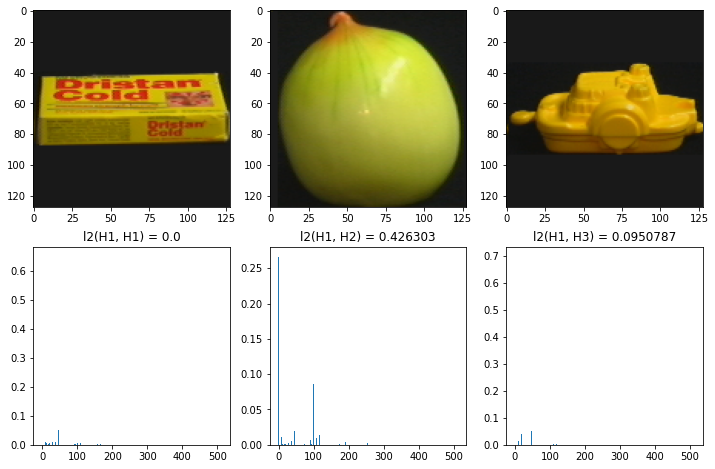

In [4]:
I1 = cv2.imread("dataset/object_01_1.png")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
h1 = myhist3(I1, 8)

I2 = cv2.imread("dataset/object_02_1.png")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)
h2 = myhist3(I2, 8)

I3 = cv2.imread("dataset/object_03_1.png")
I3 = cv2.cvtColor(I3, cv2.COLOR_BGR2RGB)
h3 = myhist3(I3, 8)

d1 = compare_histograms(h1, h1, "l2")
d2 = compare_histograms(h1, h2, "l2")
d3 = compare_histograms(h1, h3, "l2")


plt.rcParams["figure.figsize"] = (12,8)

plt.subplot(231)
plt.imshow(I1)
plt.subplot(232)
plt.imshow(I2)
plt.subplot(233)
plt.imshow(I3)
plt.subplot(234)
plt.title("l2(H1, H1) = {:.6}".format(d1))
plt.bar(np.arange(8**3), h1.reshape(-1))
plt.subplot(235)
plt.title("l2(H1, H2) = {:.6}".format(d2))
plt.bar(np.arange(8**3), h2.flatten())
plt.subplot(236)
plt.title("l2(H1, H3) = {:.6}".format(d3))
plt.bar(np.arange(8**3), h3.reshape(-1))

plt.show()

The last one is the most similar in all four distances. The most expressed color is black, because it is the most common pixel color.

In [5]:
def directory_histograms(directory, n_bins):
	l = {}
	for img in os.listdir(directory):
		d = os.path.join(directory, img)
		I = cv2.imread(d)
		I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
		h1 = myhist3(I, n_bins)
		l[d] = h1.flatten()
	return l

In [6]:
n_bins = 8
histograms = directory_histograms("dataset", n_bins)

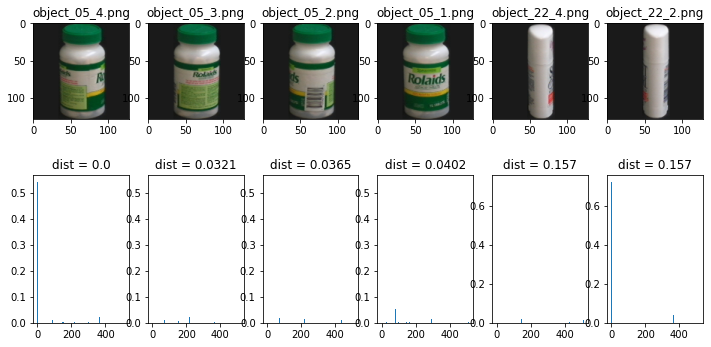

In [7]:
def plot_most_similar(histograms):
	selected = histograms["dataset/object_05_4.png"]
	l = []
	for i, (d, hist) in enumerate(histograms.items()):
		dist = compare_histograms(selected, hist, "chi")
		l.append([d, hist, dist, i])

	dists1 = [x[2] for x in l]
	l.sort(key=lambda x: x[2])
	dists2 = [x[2] for x in l]

	n = 6

	plt.rcParams["figure.figsize"] = (12,6)
	for i in range(n):
		I = cv2.imread(l[i][0])
		I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
		plt.subplot(2, n, i+1)
		plt.title(os.path.basename(l[i][0]))
		plt.imshow(I)
		plt.subplot(2, n, n+1+i)
		plt.title("dist = {:.3}".format(l[i][2]))
		plt.bar(np.arange(len(l[i][1])), l[i][1])
	plt.show()
	return l, n, dists1, dists2
l, n, dists1, dists2 = plot_most_similar(histograms)

For small n_bins (6 or less) the las ttwo images (which show another objects) are different depending on n_bins. Time is affected by n_bins (cca 10s for 4, 45s for 16).

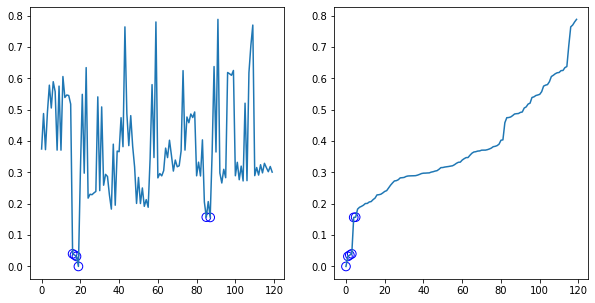

In [8]:
def plot_distance(l,n, dists1, dists2):
	plt.rcParams["figure.figsize"] = (10,5)
	plt.subplot(121)
	plt.plot(dists1)
	plt.scatter([l[i][3] for i in range(n)], [l[i][2] for i in range(n)], s=75, edgecolors="b", facecolors='none')
	plt.subplot(122)
	plt.plot(dists2)
	plt.scatter([i for i in range(n)], [l[i][2] for i in range(n)], s=75, edgecolors="b", facecolors='none')
	plt.show()
plot_distance(l, n, dists1, dists2)

## (f) F (10 points)

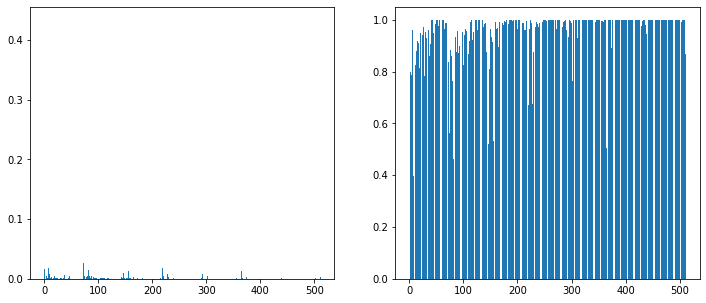

In [9]:
f = np.zeros(n_bins**3, dtype="float")
for d, x in histograms.items():
	f += x
f /= len(histograms)

lamb = 50
weights = np.exp(-lamb*f)


plt.rcParams["figure.figsize"] = (12,5)
plt.subplot(121)
plt.bar(np.arange(len(f)), f)
plt.subplot(122)
plt.bar(np.arange(len(weights)), weights)
plt.show()


In [10]:
histograms_w = {}
for k, h in histograms.items():
	new_h = h*weights
	histograms_w[k] = new_h/sum(new_h)

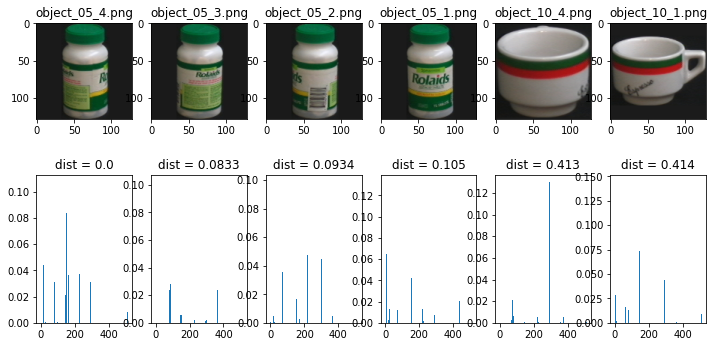

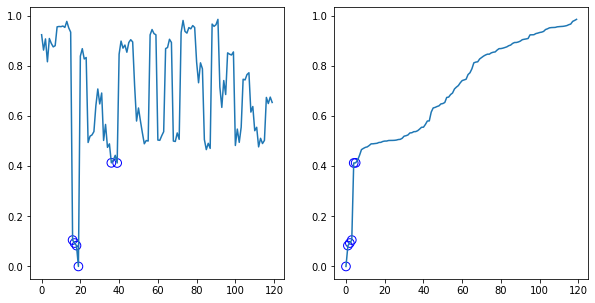

In [11]:
l_w, n_w, dists1_w, dists2_w = plot_most_similar(histograms_w)
plot_distance(l_w, n_w, dists1_w, dists2_w)

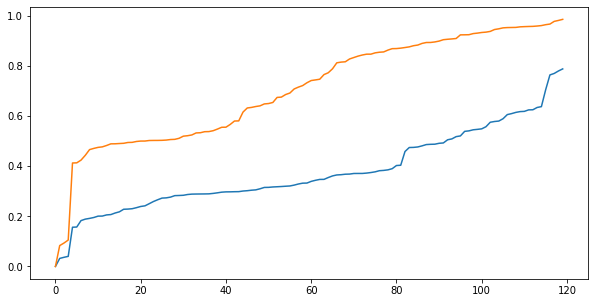

In [12]:
plt.plot(dists2)
plt.plot(dists2_w)
plt.show()

Weighting helped increase the difference in distance between pictures of the same object and the others. Bins representing black dominate.

---
# Exercise 2: Convolution

```
result[1] = k[0]*f[2] + k[1]*f[1] + k[2]*f[0] = 0.5*1 + 1*1 + 0.3*0 = 1.5

result[2] = k[0]*f[3] + k[1]*f[2] + k[2]*f[1] = 0.5*1 + 1*1 + 0.3*1 = 1.8

result[3] = k[0]*f[4] + k[1]*f[3] + k[2]*f[2] = 0.5*0 + 1*1 + 0.3*1 = 1.3

result[4] = k[0]*f[5] + k[1]*f[4] + k[2]*f[3] = 0.5*0.7 + 1*0 + 0.3*1 = 0.65

result[5] = k[0]*f[6] + k[1]*f[5] + k[2]*f[4] = 0.5*0.5 + 1*0.7 + 0.3*0 = 0.95

result[6] = k[0]*f[7] + k[1]*f[6] + k[2]*f[5] = 0.5*0.2 + 1*0.5 + 0.3*0.7 = 0.81

result[7] = k[0]*f[8] + k[1]*f[7] + k[2]*f[6] = 0.5*0 + 1*0.2 + 0.3*0.5 = 0.35

result[8] = k[0]*f[9] + k[1]*f[8] + k[2]*f[7] = 0.5*0 + 1*0 + 0.3*0.2 = 0.06

result[9] = k[0]*f[10] + k[1]*f[9] + k[2]*f[8] = 0.5*1 + 1*0 + 0.3*0 = 0.5

result[10] = k[0]*f[11] + k[1]*f[10] + k[2]*f[9] = 0.5*0 + 1*1 + 0.3*0 = 1.0
```


In [13]:
from a2_utils import *

In [14]:
def simple_convolution(I, k):
	n = int((len(k) - 1)/2)
	res = np.zeros(len(I) - 2*n)
	for i in range(n, len(I) - n):
		res[i-n] = np.sum(I[i-n:i+n+1]*k[::-1])
	return res

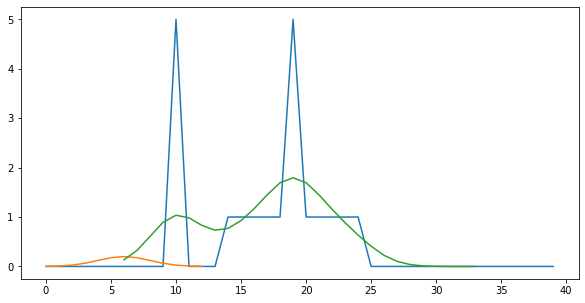

In [15]:
signal = read_data("signal.txt")
kernel = read_data("kernel.txt")
conv = simple_convolution(signal, kernel)
plt.plot(signal)
plt.plot(kernel)
plt.plot(np.arange((len(kernel) - 1)/2, (len(kernel) - 1)/2 + len(conv)), conv)
plt.show()

It's a Gaussian, sum is 1. It filters out high frequencies - smoothing.

## (c) F (5 points)

In [16]:
def simple_convolution2(I, k):
	n = int((len(k) - 1)/2)
	J = np.zeros(len(I) + 2*n)
	J[n:n+len(I)] = I
	return simple_convolution(J, k)

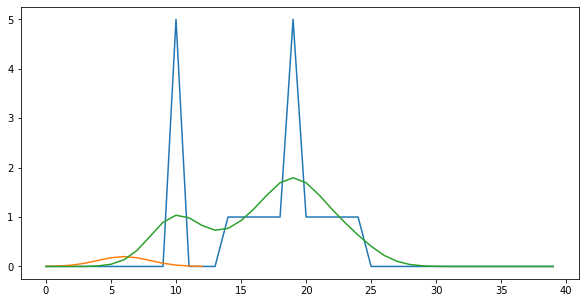

In [17]:
conv = simple_convolution2(signal, kernel)
plt.plot(signal)
plt.plot(kernel)
plt.plot(conv)
plt.show()

In [18]:
def gaussian(x, sigma=1):
	return np.exp(-x**2 / (2*sigma**2)) / (sigma*np.sqrt(2*np.pi))

def gaussian_kernel(sigma):
	tris = np.ceil(3*sigma)
	x = np.arange(-tris, tris+1)
	g = gaussian(x, sigma)
	return g / np.sum(g)

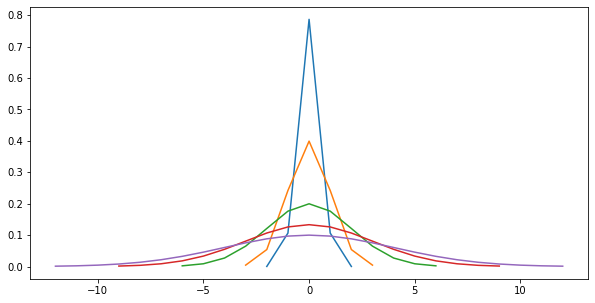

In [19]:
for i in [0.5, 1,2,3,4]:
	plt.plot(np.arange(-np.ceil(3*i), np.ceil(3*i)+1), gaussian_kernel(i))

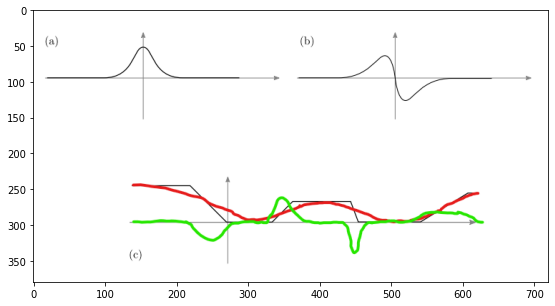

In [20]:
I = cv2.imread("Screenshot 2021-11-01 192812.png")
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
plt.imshow(I)

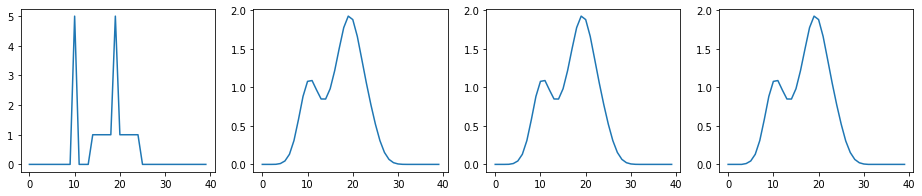

In [21]:
k1 = gaussian_kernel(2)
k2 = np.array([0.1, 0.6, 0.4])
k3 = simple_convolution2(k1, k2)
s = read_data("signal.txt")

plt.rcParams["figure.figsize"] = (16,3)
plt.subplot(141)
plt.plot(s)
plt.subplot(142)
plt.plot(simple_convolution2(simple_convolution2(s, k1), k2))
plt.subplot(143)
plt.plot(simple_convolution2(simple_convolution2(s, k2), k1))
plt.subplot(144)
plt.plot(simple_convolution2(s, k3))

---
# Exercise 3: Image filtering


In [22]:
def gaussfilter(I, sigma):
	ker = gaussian_kernel(sigma)
	I = cv2.filter2D(I, -1, ker)
	I = cv2.filter2D(I.T, -1, ker)
	return I.T

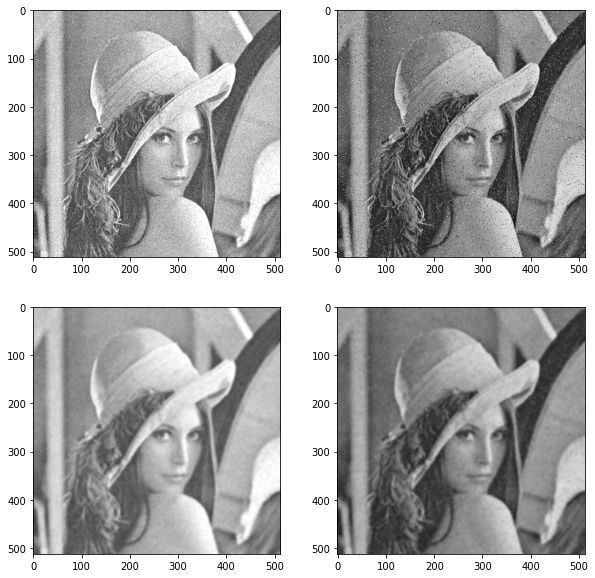

In [58]:
I = cv2.imread("images/lena.png")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

iga = gauss_noise(I, 75)
isp = sp_noise(I, 0.02)

igaf = gaussfilter(iga, 2)
ispf = gaussfilter(isp, 2)

plt.rcParams["figure.figsize"] = (10,10)
plt.subplot(221)
plt.imshow(iga, cmap="gray", vmin=0, vmax=255)
plt.subplot(222)
plt.imshow(isp, cmap="gray", vmin=0, vmax=255)
plt.subplot(223)
plt.imshow(igaf, cmap="gray", vmin=0, vmax=255)
plt.subplot(224)
plt.imshow(ispf, cmap="gray", vmin=0, vmax=255)
plt.show()

In [24]:
def unsharp_mask(I):
	I2 = I.astype(float)
	ker = np.ones((3, 3))
	conv = cv2.filter2D(I2.copy(), -1, ker)
	res = 2*I2 - conv/9
	return np.clip(res, 0, 255).astype("uint8")

[]

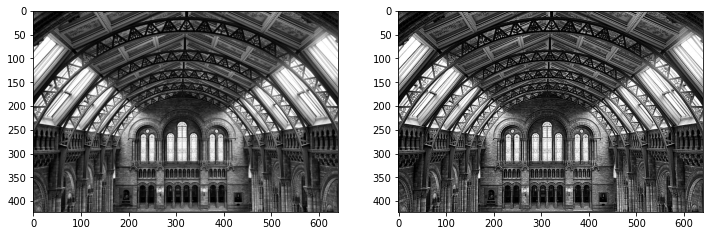

In [25]:
I = cv2.imread("images/museum.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

ish = unsharp_mask(I )

plt.rcParams["figure.figsize"] = (12,6)
plt.subplot(121)
plt.imshow(I, cmap="gray")
plt.subplot(122)
plt.imshow(ish, cmap="gray")
plt.plot()

In [26]:
def simple_median(I, w):
	n = len(I) - w + 1
	res = np.zeros(n)
	for i in range(n):
		res[i] = np.median(I[i:i+w])
	return res


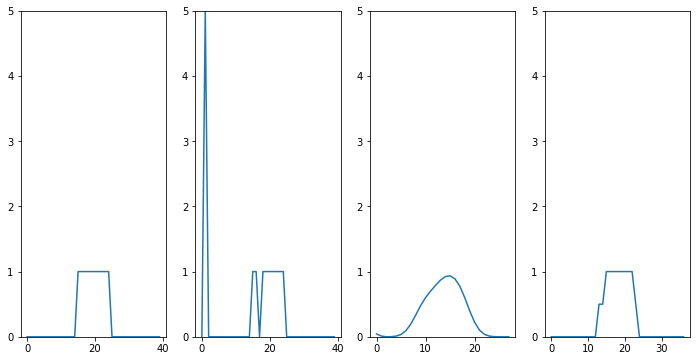

In [34]:
signal = np.zeros((40))
signal[15:25] = 1
corrupted = signal.copy()
corrupted[np.random.rand(signal.shape[0])<0.05]=0
corrupted[np.random.rand(signal.shape[0])<0.05]=5

g = simple_convolution(corrupted, gaussian_kernel(2))
m = simple_median(corrupted, 4)

plt.rcParams["figure.figsize"] = (12,6)
plt.subplot(141, ylim=(0,5))
plt.plot(signal)
plt.subplot(142, ylim=(0,5))
plt.plot(corrupted)
plt.subplot(143, ylim=(0,5))
plt.plot(g)
plt.subplot(144, ylim=(0,5))
plt.plot(m)
plt.show()

In [28]:
def simple_median2d(I, w):
	n1 = I.shape[0] - w + 1
	n2 = I.shape[1] - w + 1
	res = np.zeros((n1, n2))
	for i in range(n1):
		for j in range(n2):
			res[i, j] = np.median(I[i:i+w, j:j+w])
	return res

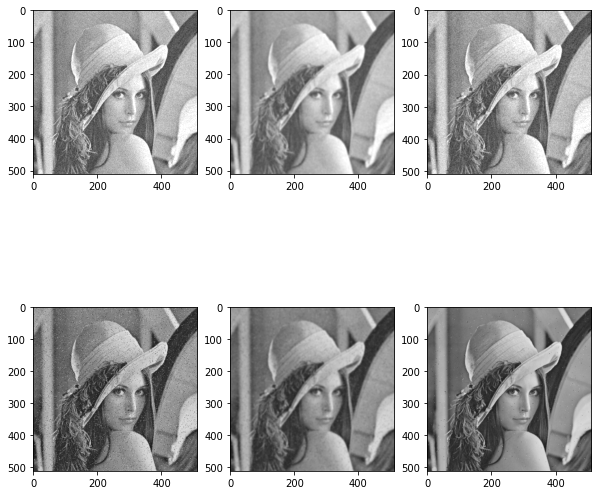

In [59]:
I = cv2.imread("images/lena.png")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

iga = gauss_noise(I, 75)
isp = sp_noise(I, 0.02)

igaf = gaussfilter(iga, 2)
ispf = gaussfilter(isp, 2)

igam = simple_median2d(iga, 2)
ispm = simple_median2d(isp, 2)

plt.rcParams["figure.figsize"] = (10,10)
plt.subplot(231)
plt.imshow(iga, cmap="gray", vmin=0, vmax=255)
plt.subplot(234)
plt.imshow(isp, cmap="gray", vmin=0, vmax=255)
plt.subplot(232)
plt.imshow(igaf, cmap="gray", vmin=0, vmax=255)
plt.subplot(235)
plt.imshow(ispf, cmap="gray", vmin=0, vmax=255)
plt.subplot(233)
plt.imshow(igam, cmap="gray", vmin=0, vmax=255)
plt.subplot(236)
plt.imshow(ispm, cmap="gray", vmin=0, vmax=255)
plt.show()

m.. n. of pixels

N .. length or width of kernel


Gaussian : O(m*N)

Median: : O(m* N^2*logN^2)

In [30]:
def gaussian2d(x, y, sigma):
	return np.exp(-(x**2 + y**2) / (2*sigma**2)) / (sigma*np.sqrt(2*np.pi))

def gaussian_kernel2d(sigma):
	tris = int(np.ceil(3*sigma))
	x = np.arange(-tris, tris+1)
	x = np.tile(x, (2*tris+1, 1)).T
	y = np.arange(-tris, tris+1)
	y = np.tile(y, (2*tris+1, 1))
	g = gaussian2d(x, y, sigma)
	return g / np.sum(g)

def laplacian_kernel(sigma):
	k = -gaussian_kernel2d(sigma)
	k[3*sigma, 3*sigma] = 1
	return k/np.sum(k)

def laplacian_filter(I, sigma):
	ker = laplacian_kernel(sigma)
	I = cv2.filter2D(I, -1, ker)
	return I

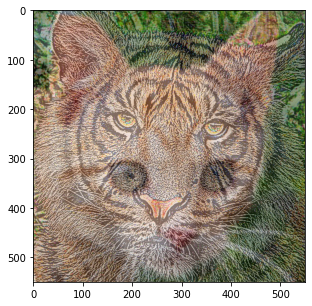

In [31]:
I = cv2.imread("images/cat1.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGBA)
I2 = cv2.imread("images/cat2.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

gauss = np.zeros_like(I2)
lapl = np.zeros_like(I2)
for i in range(3):
	gauss[:,:,i] = gaussfilter(I[:,:,i], 2)
	lapl[:,:,i] = laplacian_filter(I2[:,:,i], 2)


plt.rcParams["figure.figsize"] = (5,5)
l = lapl*0.4
g = gauss*0.6
r = g+l
plt.imshow(r.astype("uint8"))